<a href="https://colab.research.google.com/github/indremontvilaite/class_b_lidaris/blob/main/Lidaris01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem: LIDT(Laser Induced Damage Testing) in Deep Learning
The task is to create DL model which would indentify damaged images. Dataset is 400 high quality pictures of laser-induced optics.


*   Model selection:\
Unet and CNN model are selected for damage indentification.
*   Data preparation:
   1. Images were squared (*size=1944*) and cropped into 36 peaces(*size=324*) to remain the quality and fit the size for training a model. 
  2. The other approach is to disregard image quality and resize squared images to *size=1944*
  3. For Unet model, segmentation masks were created by using COCO annotations. Polygins on damaged places were drown manually. Annotated mask were squared and cropped or resized as the images.
  
*  Modelling:\
CNN model: 
  1. Resnet34 with resized images, normalization, lr tuning
  2. Resnet50 with resized images, normalization, lr tuning, augmentation, regularization wd, loss function to emphasize damages 
  3. My own build model

  Unet model:
  1.   Resnet34 with cropped images, basic data augmentation, normalization, lr tuning
  2.   Resnet34 with resized images, normalization, lr tuning

* Results:

| Model | Valid loss| Metric: Error rate | Metric: Dice |
| --- | --- | --- | --- |
| Unet crop, augmented | 0.040942| | 	0.416256 |
| Unet resize| 0 | |None|
|CNN basic| 0.269270 |	0.128205| |
|CNN augmented| 0.617627| 	0.205128| |
|My CNN, no damage detected| 0.453038| 	0.166667 | |









# Notebook setup

In [2]:
!pip install git+https://github.com/fastai/fastai -qq

     |████████████████████████████████| 61kB 6.4MB/s 


In [3]:
!pip install nbdev -qq

     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 


In [1]:
import fastai 
from fastai.vision.all import *
from nbdev.showdoc import *

In [2]:
fastai.__version__

'2.3.1'

In [3]:
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from numpy import asarray
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
import numpy as np
import skimage.io as io
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import Binarizer
import IPython
%matplotlib inline

In [ ]:
# !unzip '/content/drive/MyDrive/Data/Lidaris/S002152_T002998.zip'

# Images

In [4]:
!cp -f /content/drive/MyDrive/Data/Lidaris/functions.py .

In [5]:
%cd '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/'

/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos


<Figure size 432x288 with 0 Axes>

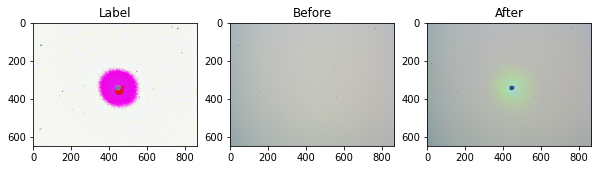

In [ ]:
import functions
functions.sub_plots(10, 3, 'Unmaged example')

<Figure size 432x288 with 0 Axes>

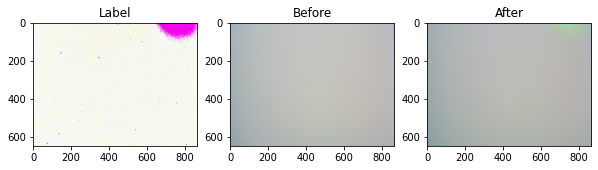

In [ ]:
functions.sub_plots(5, 3, 'Undamaged example')

<Figure size 432x288 with 0 Axes>

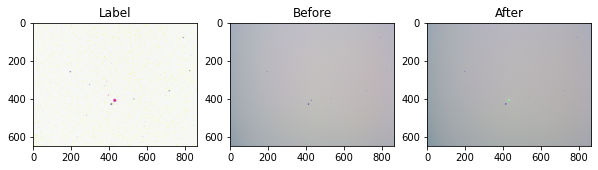

In [ ]:
#photo with a little damage
functions.sub_plots(36, 3, 'A little damaged example')

# COCO dataset

In [ ]:
!cp -f /content/drive/MyDrive/Data/Lidaris/CocoDataset.py .
import CocoDataset

In [ ]:
annotation_path = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/10x_after/annotations_coco.json'
image_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/10x_after'
coco_dataset = CocoDataset.CocoDataset(annotation_path, image_dir)
coco_dataset.display_categories()

Categories:
    id 1: 0
    id 2: 1



Image:
  id: 7
  width: 2592
  height: 1944
  file_name: site67.jpg
  segmentations (1):
    6:blue:{'id': 2, 'name': '1'}



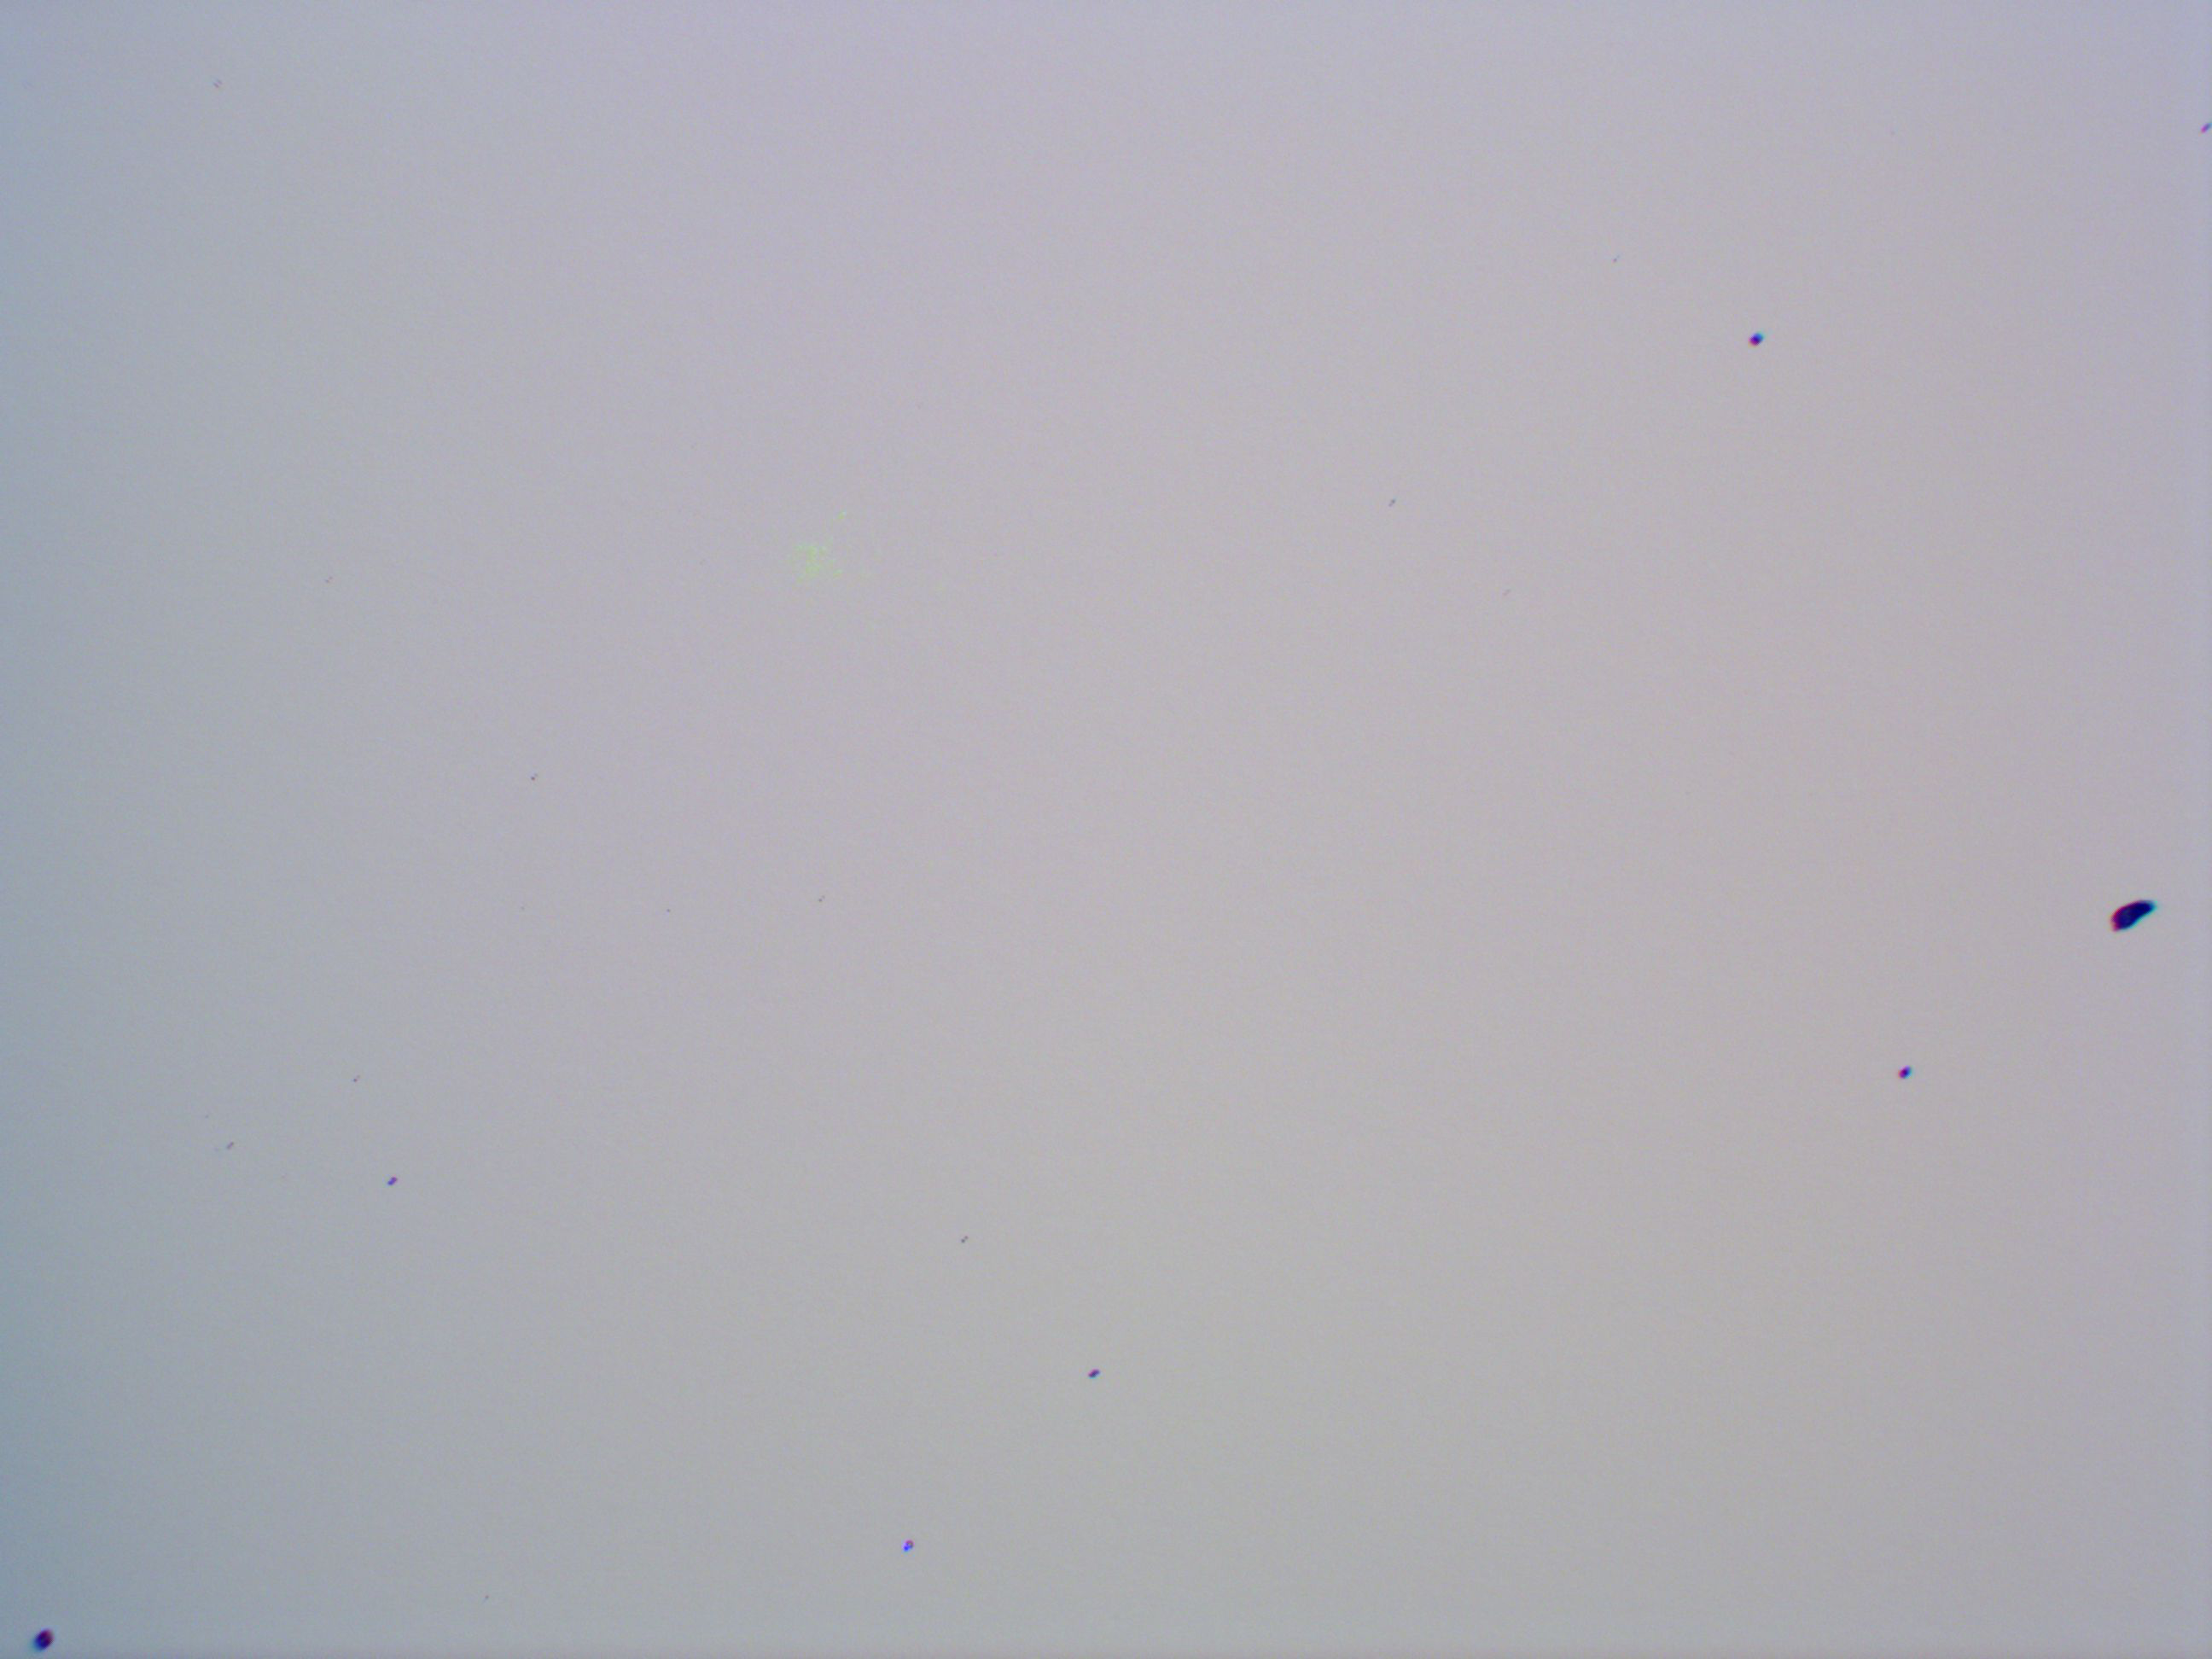

In [ ]:
ann_7 = coco_dataset.display_image(7, use_url=False)
IPython.display.HTML(ann_7)

# Mask

In [ ]:
annotation_path = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/10x_after/annotations_coco.json'
image_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/10x_after'

coco=COCO(annotation_path)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[{'id': 1, 'name': '0'}, {'id': 2, 'name': '1'}]


Number of images containing damages: 91


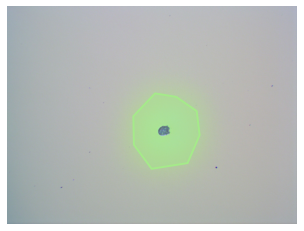

In [ ]:
filterClasses = ['0', '1']
catIds = coco.getCatIds(catNms=filterClasses) 
imgIds = coco.getImgIds()
print("Number of images containing damages:", len(imgIds))

img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/{}'.format(image_dir,img['file_name']))/255.0

plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [ ]:
catIds = coco.getCatIds()
mask_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/mask_after'

functions.empty_mask(image_dir, mask_dir)
functions.create_mask(mask_dir, coco, catIDs)

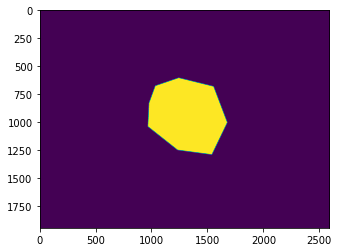

In [ ]:
plt.imshow(coco.annToMask(anns[0]))

In [ ]:
np.unique(coco.annToMask(anns[0]))

array([0, 1], dtype=uint8)

# Image preprocesing
## Crop image

In [ ]:
out_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/crop_after1'
image_nm = functions.image_names(image_dir)

# for name in image_nm:
#   functions.tile(name, image_dir, out_dir, 324)

In [ ]:
#os.mkdir('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/square_mask')

In [ ]:
crop_mask_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/crop_mask'
mask_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/mask_after'
mask_square = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/square_mask'
mask_nm = functions.image_names(mask_dir)

# for name in mask_nm:
#   functions.tile(name, mask_dir, crop_mask_dir, 324)

for name in mask_nm:
  functions.tile(name, mask_dir, mask_square, 1944)

In [ ]:
image_dir = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/10x_after'
out_square = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/square_after'
image_nm = functions.image_names(image_dir)

for name in image_nm:
  functions.tile(name, image_dir, out_square, 1944)

# Fastai way
## Unet

In [6]:
path2 = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/'
tab_data = pd.read_excel(os.path.join(path2, 'S002152_T002998_MD.xlsx'))
tab_data.head()

Site Nr.   Xc, mm  ...  Insp Pulses passed(F)  Fluency Mean, J/cm2
0         1 -3181981  ...                      1              1035474
1         2  -212132  ...                     90              6877587
2         3  -106066  ...                     33              7923886
3         4        0  ...                   1000              1004169
4         5   106066  ...                   1000              1960314

[5 rows x 6 columns]

In [7]:
not_valid = tab_data.loc[tab_data['Insp. Status'].isin([-2, -1])]
not_valid['Site_nr'] =['site{}'.format(not_valid.iloc[i,0]) for i in range(len(not_valid))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


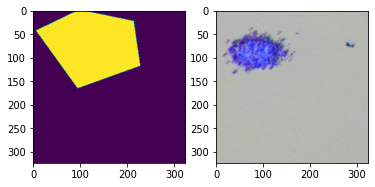

In [12]:
import functions
path = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/'

fnames = get_image_files(os.path.join(path, 'crop_after1'))
img_f = fnames[3025]
mask = PILMask.create(functions.get_mask(path, img_f,'crop_mask'))
img = PILImage.create(img_f)

ax = plt.subplot(1, 2, 1)
plt.imshow(mask)
ax = plt.subplot(1, 2, 2)
plt.imshow(img)

In [ ]:
mask = asarray(Image.open(os.path.join(path, 'mask_after', 'mask_site101.png')))
np.unique(mask)

array([0, 1], dtype=int32)

In [8]:
def get_image_filter(path, not_valid=not_valid):
    fnames = get_image_files(path)
    fnames2 = get_image_files(path)
    b = not_valid["Site_nr"].copy()
    for i in fnames:
        if i.stem.split("_")[0] in list(b):
            fnames2.remove(i)
    return fnames2

def get_mask(y, folder="crop_mask"):
    return os.path.join(path, folder, f"mask_{y.stem}.png")

In [9]:
lidaris = DataBlock(blocks = (ImageBlock, MaskBlock(['0', '1'])),
                   get_items = get_image_filter,
                   splitter = RandomSplitter(),
                   get_y = get_mask,
                   batch_tfms = [*aug_transforms(size=(324,324)), Normalize])

lidaris_rsize = DataBlock(blocks = (ImageBlock, MaskBlock(['0', '1'])),
                   get_items = get_image_filter,
                   splitter = RandomSplitter(),
                   get_y = get_mask,
                   item_tfms = Resize((324, 324)),
                   batch_tfms = Normalize)

In [13]:
dls = lidaris.dataloaders(os.path.join(path, 'crop_after1'), path=path, bs=8)
dls_rsize = lidaris_rsize.dataloaders(os.path.join(path, 'square_after'), path=path, bs=8, folder='square_mask')

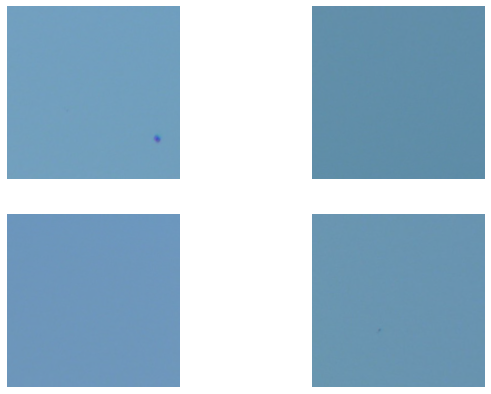

In [14]:
dls.show_batch(max_n=4, figsize=(10,7))

In [27]:
del learn
import gc
gc.collect()

27591

In [136]:
learn = unet_learner(dls, resnet34, metrics=Dice)
#learn_rsize = unet_learner(dls_rsize, resnet34, metrics=Dice)

In [ ]:
learn.model

SuggestedLRs(lr_min=0.00019008662784472107, lr_steep=3.129134711343795e-05)

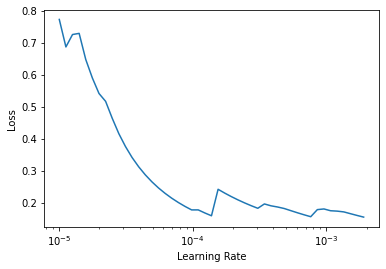

In [16]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
learn.lr_find(start_lr=1e-05, end_lr=0.9,)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.0892961401841603e-05)

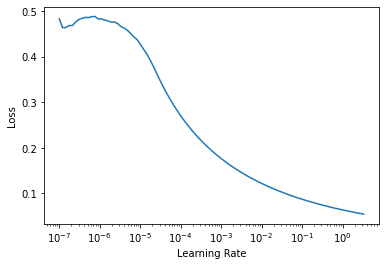

In [19]:
learn_rsize.lr_find()

In [17]:
lr = 1.9e-4
learn.fit_one_cycle(1, slice(lr))

In [20]:
lr_rsize = 1e-4
learn_rsize.fit_one_cycle(1, slice(lr_rsize))

In [18]:
learn.save('stage-1')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/models/stage-1.pth')

In [21]:
learn_rsize.save('rsize-1')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/models/rsize-1.pth')

In [23]:
learn_rsize.load('rsize-1')
learn_rsize.unfreeze()

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0006918309954926372)

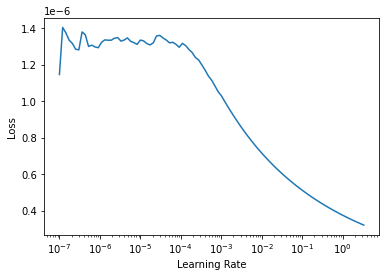

In [24]:
learn_rsize.lr_find()

In [25]:
lr_rsize = 3.3e-1
learn_rsize.fit_one_cycle(6, slice(lr_rsize))

In [26]:
learn_rsize2 = unet_learner(dls_rsize, resnet34, metrics=Dice, pretrained=False)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=1.737800812406931e-05)

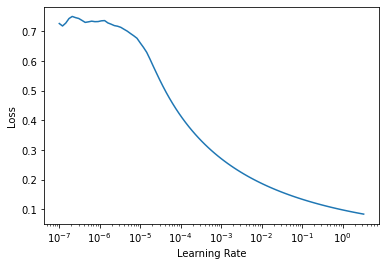

In [30]:
learn_rsize2.lr_find()

In [31]:
lr_rsize = 3.3e-1
learn_rsize2.fit_one_cycle(6, slice(lr_rsize))

In [137]:
learn.load('stage-1')
learn.unfreeze()

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=6.309573450380412e-07)

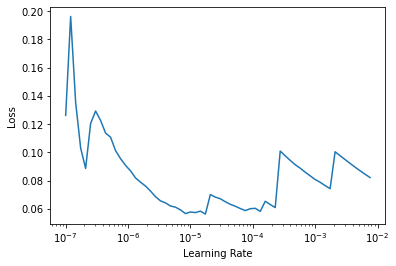

In [139]:
learn.lr_find()

In [140]:
lr = 1.73e-6
learn.fit_one_cycle(6, slice(lr), pct_start=0.8, wd=1e-2)

In [141]:
learn.save('stage-2')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/Photos/models/stage-2.pth')

In [ ]:
learn.load('stage-2')

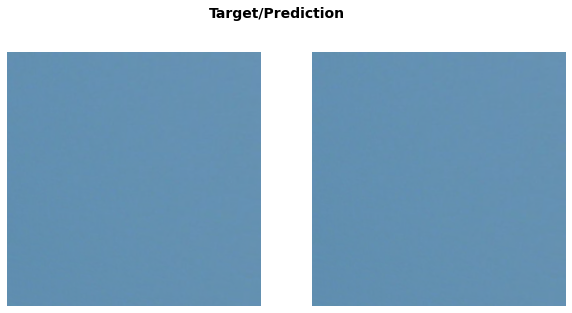

In [142]:
learn.show_results(ds_idx=0, max_n=1, figsize=(10, 5), vmin=1, vmax=30)

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(4, figsize(8,8))

## Classification problem

In [33]:
path2 = '/content/drive/MyDrive/Data/Lidaris/S002152_T002998'

In [34]:
y_labels = tab_data["Insp. Status"]

def get_y_labels(x):
    i = int(x.stem.split('_')[0].split('site')[1])
    
    return tab_data["Insp. Status"][i-1]

In [113]:
lidaris2 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_filter,
                   splitter = RandomSplitter(),
                   get_y = get_y_labels,
                   item_tfms = Resize((324, 324)),
                   batch_tfms = Normalize)

In [114]:
dls2 = lidaris2.dataloaders(os.path.join(path2, 'Photos','square_after'), path=path2, bs=8)

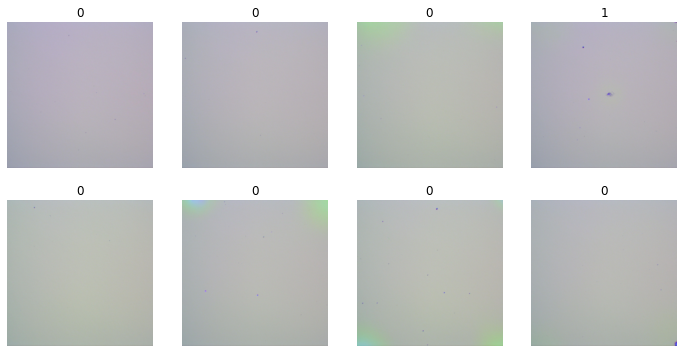

In [ ]:
dls2.show_batch()

In [115]:
def conv2(ni,nf): return ConvLayer(ni,nf,stride=2)

class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf,nf)
        self.conv2 = ConvLayer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [116]:
model2 = nn.Sequential(
    conv2(3, 8),
    ResBlock(8),
    conv2(8, 16),
    ResBlock(16),
    conv2(16, 32),
    ResBlock(32),
    conv2(32, 16),
    ResBlock(16),
    conv2(16, 1),
    Flatten()
)

In [120]:
learn2 = Learner(dls2, model2, metrics=error_rate)

In [ ]:
learn2.summary()

In [122]:
dls2 = dls2.cuda()

SuggestedLRs(lr_min=0.03801893889904022, lr_steep=0.006760829593986273)

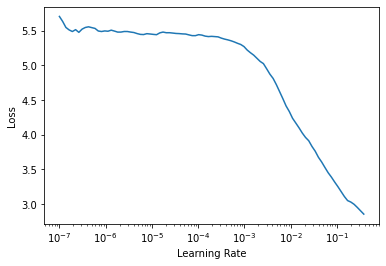

In [123]:
learn2.lr_find(end_lr=1)

In [124]:
lr2 = 3.8e-2
learn2.fit_one_cycle(12,  slice(lr2))

In [125]:
learn2.save('mymodel_stage1')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/models/mymodel_stage1.pth')

In [126]:
interp2 = ClassificationInterpretation.from_learner(learn2)

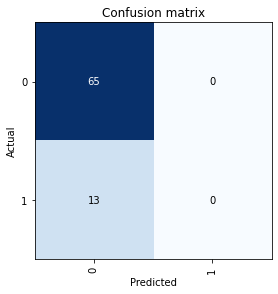

In [128]:
interp2.plot_confusion_matrix()

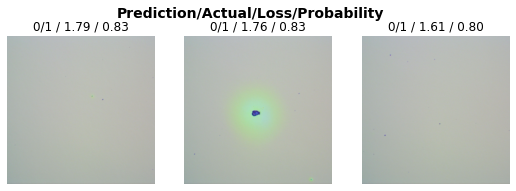

In [129]:
interp2.plot_top_losses(k=3)

In [130]:
model3 = nn.Sequential(
    conv2(3, 8),
    ResBlock(8),
    conv2(8, 16),
    ResBlock(16),
    conv2(16, 32),
    ResBlock(32),
    conv2(32, 64),
    ResBlock(64),
    conv2(64, 128),
    ResBlock(128),
    conv2(128, 64),
    ResBlock(64),
    conv2(64, 32),
    ResBlock(32),
    conv2(32, 16),
    ResBlock(16),
    conv2(16, 1),
    Flatten()
)

In [134]:
dls2.vocab

[0, 1]

In [131]:
weights = [1.0, 5.0]
class_weights = torch.FloatTensor(weights).cuda()
learn_my = Learner(dls2, model2, loss_func = nn.CrossEntropyLoss(weight=class_weights), metrics=error_rate)

In [ ]:
learn_my.lr_find()

## CNN model

In [ ]:
learn3 = cnn_learner(dls2, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.003388441726565361, lr_steep=0.0011481536785140634)

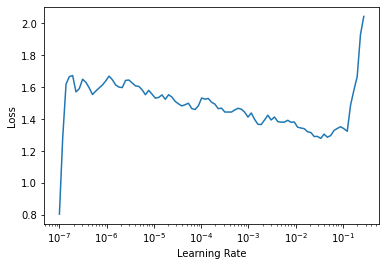

In [ ]:
learn3.lr_find(end_lr=1)

In [ ]:
lr3 = 3.3e-3
learn3.fit_one_cycle(3,  slice(lr3))

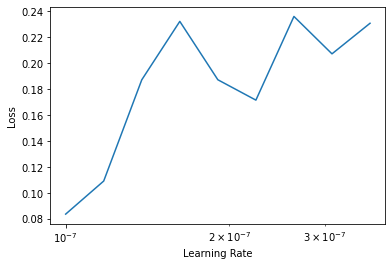

In [ ]:
learn3.unfreeze()
learn3.lr_find(end_lr=1)

In [ ]:
lr3 = 2e-7
learn3.fit_one_cycle(12,  slice(lr3))

In [ ]:
learn3.save('CNN_stage1')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/models/CNN_stage1.pth')

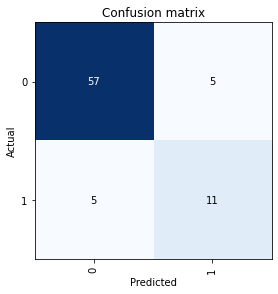

In [ ]:
interp3 = ClassificationInterpretation.from_learner(learn3)
interp3.plot_confusion_matrix(figsize=(4,4))

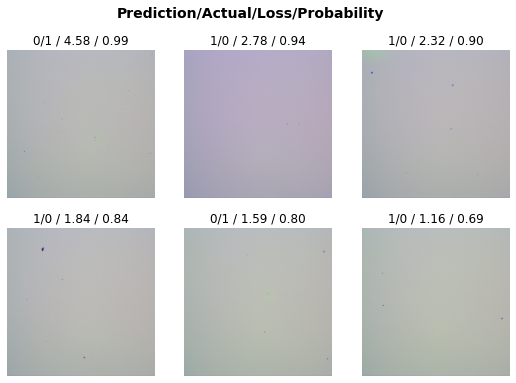

In [ ]:
interp3.plot_top_losses(k=6)

## CNN model with data augmentation, go big

In [35]:
lidaris_cnn2 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_filter,
                   splitter = RandomSplitter(),
                   get_y = get_y_labels,
                   item_tfms = Resize((324, 324)),
                   batch_tfms = [*aug_transforms(do_flip = True, flip_vert = True, max_rotate = 10), Normalize])
#

In [36]:
dls_cnn2 = lidaris_cnn2.dataloaders(os.path.join(path2, 'Photos','square_after'), path=path2, bs=8)

In [37]:
weights = [0.2, 1.0]
class_weights = torch.FloatTensor(weights).cuda()
learn_cnn2 = cnn_learner(dls_cnn2, models.resnet50, metrics=error_rate, loss_func=nn.CrossEntropyLoss(weight=class_weights), pretrained=False)
# - error: restnet34=.52, restnet50=.26 

SuggestedLRs(lr_min=0.002089296095073223, lr_steep=1.8197008557763183e-06)

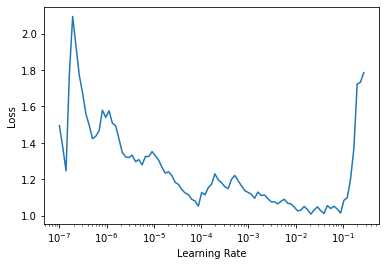

In [38]:
learn_cnn2.lr_find(end_lr=1)

In [39]:
lr_cnn2 =2e-3
learn_cnn2.fit_one_cycle(3,  slice(lr_cnn2))

In [40]:
learn_cnn2.save('CNN2_stage1')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/models/CNN2_stage1.pth')

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.5848931980144698e-06)

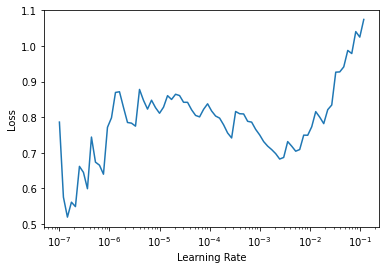

In [41]:
learn_cnn2.lr_find()

In [42]:
lr_cnn2 = 7.58e-8
learn_cnn2.fit_one_cycle(8,  slice(lr_cnn2), wd=1e-2)

In [43]:
ç.save('CNN2_stage2')

Path('/content/drive/MyDrive/Data/Lidaris/S002152_T002998/models/CNN2_stage2.pth')

## Predict using Restnet50

In [109]:
preds, targs = learn_cnn2.get_preds()
filenames = []
for i in range(len(dls_cnn2.valid_ds)):
    filenames.append(str(dls_cnn2.valid_ds.items[i]).split('/')[-1])
preds0 = [(x[0], x[1]) for x in preds]
df = pd.DataFrame(data={"prediction": preds0, "target": targs, "filename": filenames})

In [110]:
df.iloc[indices]

prediction  target         filename
21   (tensor(2.2721), tensor(0.5895))       1   site62_0_0.jpg
14   (tensor(1.5612), tensor(0.0190))       1  site117_0_0.jpg
28  (tensor(1.1101), tensor(-0.1859))       1   site74_0_0.jpg
6    (tensor(1.7310), tensor(0.5154))       1   site51_0_0.jpg

In [58]:
def get_test_image(path, not_valid=not_valid):
    fnames = get_image_files(path)
    fnames2 = []
    b = not_valid["Site_nr"].copy()
    for i in fnames:
        if i.stem.split("_")[0] in list(b):
            fnames2.append(i)
    return fnames2

test_images = get_test_image(os.path.join(path2, 'Photos','square_after'))
learn_cnn2.predict(test_images[0])

('[0, 0]', tensor([ 0.4389, -0.3609]), tensor([ 0.4389, -0.3609]))

In [ ]:
# do not predict than giving damaged image
learn_cnn2.predict(test_images[2])

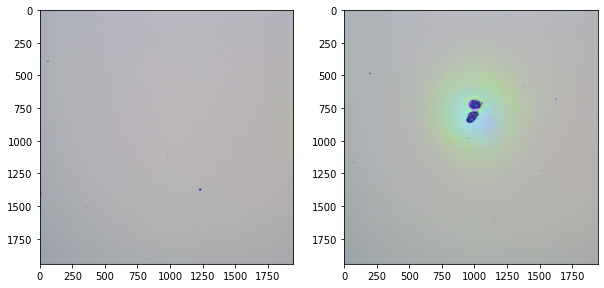

In [66]:
plt.subplots(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(Image.open(test_images[0]))
ax = plt.subplot(1, 2, 2)
plt.imshow(Image.open(test_images[2]))

# Tensorflow way